In [4]:
import numpy as np
from icecream import ic
import circle_fit as circle
from tracker_coordinate_transform import *
from trackercal import *


In [2]:
with open("circle_samples_5.txt", 'r') as file:
    circle_samples = eval(file.read())

#circle_samples

In [4]:
# negate the x values in circle_samples
circle_samples = negate_xvalues(circle_samples)

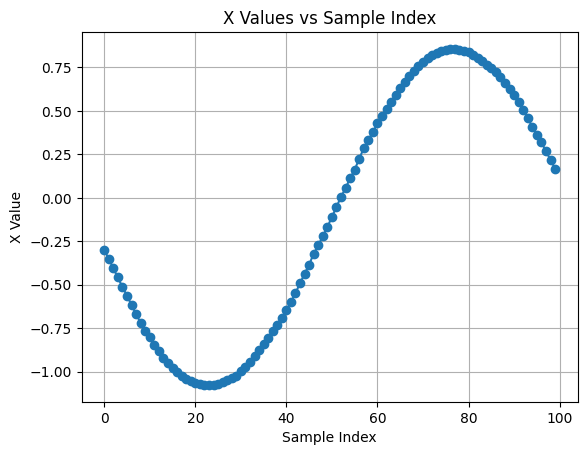

In [5]:
import matplotlib.pyplot as plt

# Extract x values
x_values_circle_samples = [point[0] for point in circle_samples]

# Plot
plt.plot(x_values_circle_samples, marker='o')
plt.title('X Values vs Sample Index')
plt.xlabel('Sample Index')
plt.ylabel('X Value')
plt.grid(True)
plt.show()


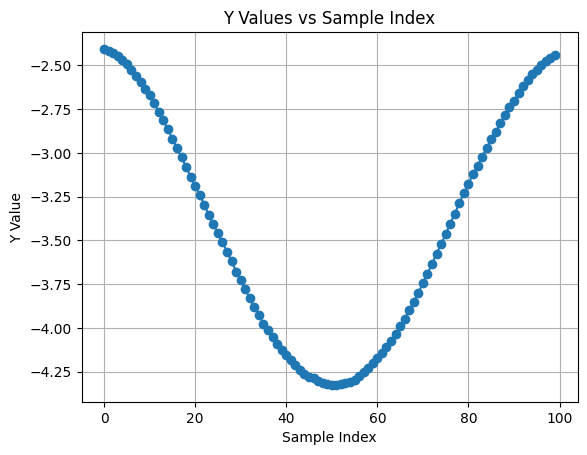

In [6]:
import matplotlib.pyplot as plt

# Extract x values
y_values_circle_samples = [point[1] for point in circle_samples]

# Plot
plt.plot(y_values_circle_samples, marker='o')
plt.title('Y Values vs Sample Index')
plt.xlabel('Sample Index')
plt.ylabel('Y Value')
plt.grid(True)
plt.show()


Calculated circle with error:  0.0070091519656960335  xc:  -0.1099970477658729  yc:  -3.3580813994032255  r:  0.9673497656586971


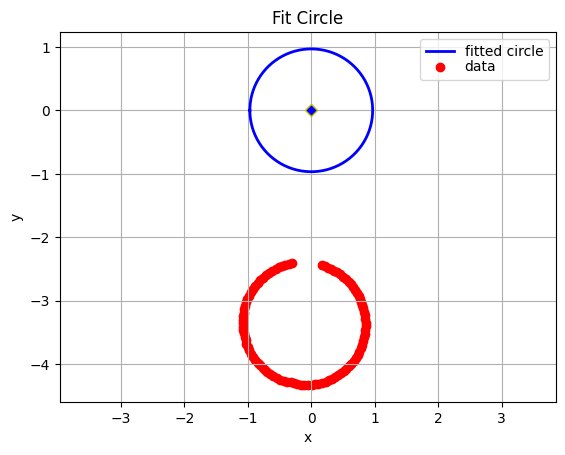

In [7]:
xc, yc, r, sigma = circle.standardLSQ(circle_samples)

print("Calculated circle with error: ", sigma, " xc: ", xc, " yc: ", yc, " r: ", r)
circle.plot_data_circle(circle_samples, 0, 0, r)


In [8]:
import numpy as np

def calculate_angle(point1, point2, center=(0, 0)):
    """
    Calculate the angle between two points on a circle with respect to the center.
    Result is in radians.
    """
    # Convert points to vectors from the center
    vector1 = np.subtract(point1, center)
    vector2 = np.subtract(point2, center)

    # Calculate the angle with atan2
    angle1 = np.arctan2(vector1[1], vector1[0])
    angle2 = np.arctan2(vector2[1], vector2[0])

    # Calculate the difference
    angle = angle2 - angle1

    # Normalize the result to be between -pi and pi
    angle = (angle + np.pi) % (2 * np.pi) - np.pi

    return angle

# Example points (x, y)
# point1 = (3, 4)
# point2 = (5, 1)
# center = (0, 0)  # Default center at (0, 0)

# angle = calculate_angle(point1, point2, center)
# print(f"Angle between points: {np.degrees(angle)} degrees")


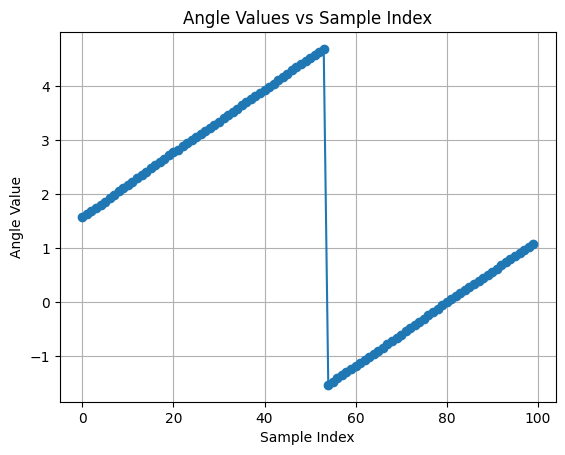

In [9]:
# Plot angle from starting point for each sample in the FRC coordinate system
# Extract angle values
angle_values = [calculate_angle(circle_samples[0],point, (xc,yc)) for point in circle_samples]
initial_angle = np.pi/2
angle_values = [(x + initial_angle) for x in angle_values]

# Plot
plt.plot(angle_values, marker='o')
plt.title('Angle Values vs Sample Index')
plt.xlabel('Sample Index')
plt.ylabel('Angle Value')
plt.grid(True)
plt.show()

In [10]:
# Calculate the (x,y) points for the calibration circle in the FRC coordinates, using the known starting point (0,r),
# known center point (0,0), the radius r, and the angle values from VR sampled data points.
FRC_circle_samples = [(r*np.cos(angle),r*np.sin(angle)) for angle in angle_values]


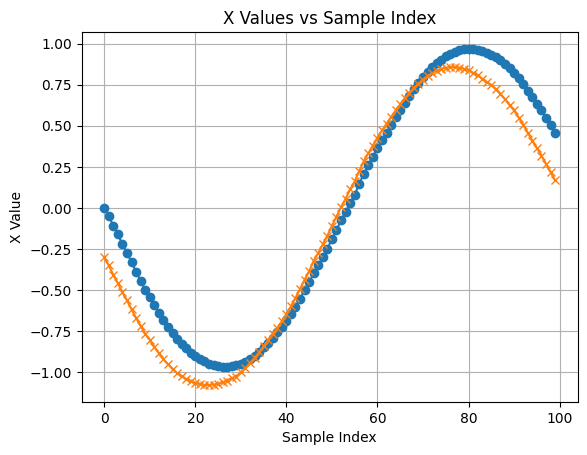

In [11]:
# Extract x values
x_values_FRC_circle_samples = [point[0] for point in FRC_circle_samples]

# Plot
plt.plot(x_values_FRC_circle_samples, marker='o')
plt.plot(x_values_circle_samples, marker='x')
plt.title('X Values vs Sample Index')
plt.xlabel('Sample Index')
plt.ylabel('X Value')
plt.grid(True)
plt.show()

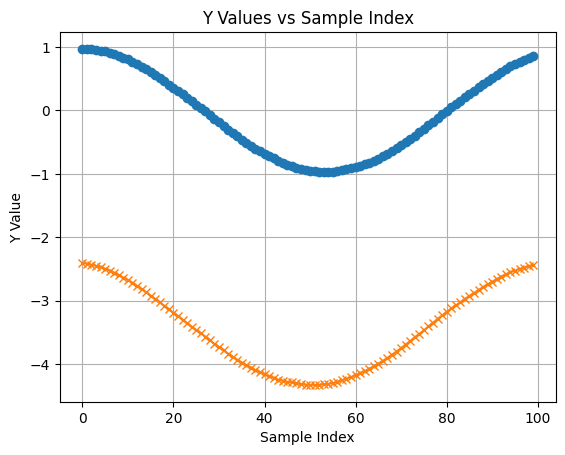

In [12]:
# Extract x values
y_values_FRC_circle_samples = [point[1] for point in FRC_circle_samples]

# Plot
plt.plot(y_values_FRC_circle_samples, marker='o')
plt.plot(y_values_circle_samples, marker='x')
plt.title('Y Values vs Sample Index')
plt.xlabel('Sample Index')
plt.ylabel('Y Value')
plt.grid(True)
plt.show()

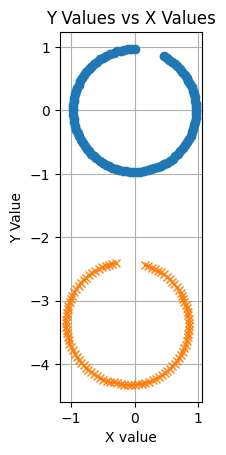

In [13]:
# Plot
# Create the plot
fig, ax = plt.subplots()


# Set aspect to be square
ax.set_aspect('equal') 
ax.plot(x_values_FRC_circle_samples, y_values_FRC_circle_samples, marker='o')
ax.plot(x_values_circle_samples, y_values_circle_samples, marker='x')
plt.title('Y Values vs X Values')
plt.xlabel('X value')
plt.ylabel('Y Value')
# Set aspect to be square
plt.grid(True)
plt.show()

In [14]:
import numpy as np

def find_transformation_params(points1, points2):
    """
    Calculate the rotation matrix, scale factor, and translation vector
    from points in system 1 to system 2.
    """
    # Convert points to numpy arrays
    points1 = np.array(points1)
    points2 = np.array(points2)

    # Find the centroids of the points
    centroid1 = np.mean(points1, axis=0)
    centroid2 = np.mean(points2, axis=0)

    # Center the points around the origin
    centered_points1 = points1 - centroid1
    centered_points2 = points2 - centroid2

    # Compute the covariance matrix
    H = np.dot(centered_points1.T, centered_points2)

    # Compute the singular value decomposition
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # Ensure that the rotation matrix is a proper rotation
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = np.dot(Vt.T, U.T)

    # Compute the scale factor
    var1 = np.var(centered_points1)
    var2 = np.var(centered_points2)
    s = np.sqrt(var2 / var1)

    # Compute the translation vector
    t = centroid2 - s * np.dot(R, centroid1)

    return R, s, t

# Sample data
# points1 = [(x1, y1), (x2, y2), ...]  # Replace with your points in system 1
# points2 = [(x1', y1'), (x2', y2'), ...]  # Replace with your corresponding points in system 2

# R, s, t = find_transformation_params(points1, points2)
# print(f"Rotation matrix: {R}")
# print(f"Scale factor: {s}")
# print(f"Translation vector: {t}")


In [15]:
def transform_coordinates(point, R, s, t):
    """
    Transform coordinates from system 1 to system 2 using the calculated
    rotation matrix, scale factor, and translation vector.
    """
    point = np.array(point)
    transformed_point = s * np.dot(R, point) + t
    return transformed_point

# Arbitrary coordinate in system 1
# arbitrary_point = (x, y)  # Replace with your point

# transformed_point = transform_coordinates(arbitrary_point, R, s, t)
# print(f"Transformed coordinates: {transformed_point}")


In [16]:
R, s, t = find_transformation_params(circle_samples, FRC_circle_samples)
print(f"Rotation matrix: {R}")
print(f"Scale factor: {s}")
print(f"Translation vector: {t}")

Rotation matrix: [[ 0.98046806  0.19667839]
 [-0.19667839  0.98046806]]
Scale factor: 0.999973602110135
Translation vector: [0.76828999 3.27076928]


In [17]:
# Try with subset of the calibration points
# sample every 5th point and then use only the first 4 points
circle_samples_subset = [point for i, point in enumerate(circle_samples) if (i + 1) % 10 == 0][:6]
print(circle_samples_subset)
FRC_circle_samples_subset = [point for i, point in enumerate(FRC_circle_samples) if (i + 1) % 10 == 0][:6]
print(FRC_circle_samples_subset)


[(-0.7655648589134216, -2.6358156204223633), (-1.0556387901306152, -3.137481451034546), (-1.026045799255371, -3.680377960205078), (-0.6894568800926208, -4.1250810623168945), (-0.16872051358222961, -4.321870803833008), (0.3792930841445923, -4.202536106109619)]
[(np.float64(-0.4965684258428598), np.float64(0.8301718903792639)), (np.float64(-0.880433128248807), np.float64(0.4007531357356496)), (np.float64(-0.9578395005150866), np.float64(-0.13531097654272414)), (np.float64(-0.7235328773683952), np.float64(-0.6420792353650342)), (np.float64(-0.2475868269136551), np.float64(-0.9351290457785835)), (np.float64(0.3108785099416566), np.float64(-0.916034999973468))]


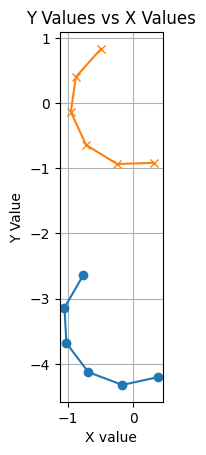

In [18]:
# Plot
# Create the plot
fig, ax = plt.subplots()
# Extract x,y values
x_values_circle_samples_subset = [point[0] for point in circle_samples_subset]
y_values_circle_samples_subset = [point[1] for point in circle_samples_subset]

x_values_FRC_circle_samples_subset = [point[0] for point in FRC_circle_samples_subset]
y_values_FRC_circle_samples_subset = [point[1] for point in FRC_circle_samples_subset]


# Set aspect to be square
ax.set_aspect('equal') 
ax.plot(x_values_circle_samples_subset, y_values_circle_samples_subset, marker='o')
ax.plot(x_values_FRC_circle_samples_subset, y_values_FRC_circle_samples_subset, marker='x')
plt.title('Y Values vs X Values')
plt.xlabel('X value')
plt.ylabel('Y Value')
# Set aspect to be square
plt.grid(True)
plt.show()

In [19]:
R, s, t = find_transformation_params(circle_samples_subset, FRC_circle_samples_subset)
print(f"Rotation matrix: {R}")
print(f"Scale factor: {s}")
print(f"Translation vector: {t}")

Rotation matrix: [[ 0.98028435  0.19759198]
 [-0.19759198  0.98028435]]
Scale factor: 0.9959649340207203
Translation vector: [0.76701719 3.2546268 ]


In [20]:
# transform the original set of VR sample points using the derived transformation constants. 
# These should match the "generated" FRC_circle_samples
FRC_circle_samples_verify = [transform_coordinates(point,R, s, t) for point in circle_samples]
#FRC_circle_samples_verify = [transform_coordinates(point,np.eye(2), 1.0, np.zeros(2)) for point in circle_samples] # no change configuration
print(f"Initial point (should be (0,{r})): {FRC_circle_samples_verify[0]}")

Initial point (should be (0,0.9673497656586971)): [-3.27353996e-04  9.64900820e-01]


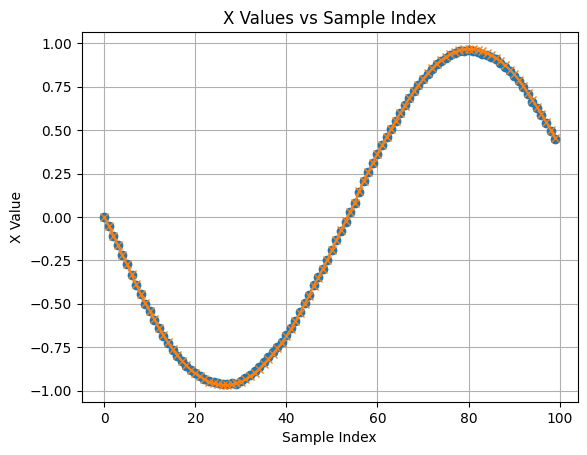

In [21]:
# Extract x values
x_values_FRC_circle_samples_verify = [point[0] for point in FRC_circle_samples_verify]

# Plot
plt.plot(x_values_FRC_circle_samples_verify, marker='o')
plt.plot(x_values_FRC_circle_samples, marker='x')
plt.title('X Values vs Sample Index')
plt.xlabel('Sample Index')
plt.ylabel('X Value')
plt.grid(True)
plt.show()

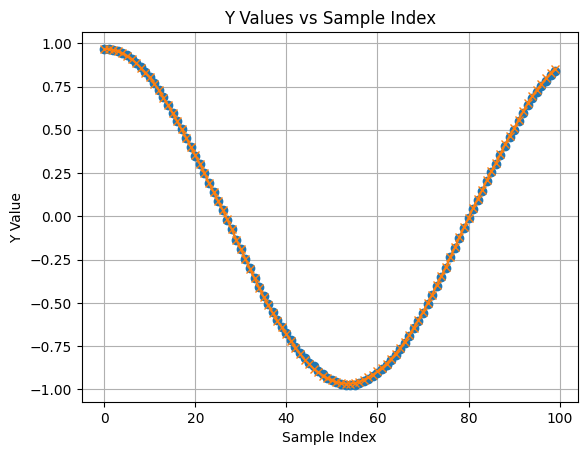

In [22]:
# Extract x values
y_values_FRC_circle_samples_verify = [point[1] for point in FRC_circle_samples_verify]

# Plot
plt.plot(y_values_FRC_circle_samples_verify, marker='o')
plt.plot(y_values_FRC_circle_samples, marker='x')
plt.title('Y Values vs Sample Index')
plt.xlabel('Sample Index')
plt.ylabel('Y Value')
plt.grid(True)
plt.show()

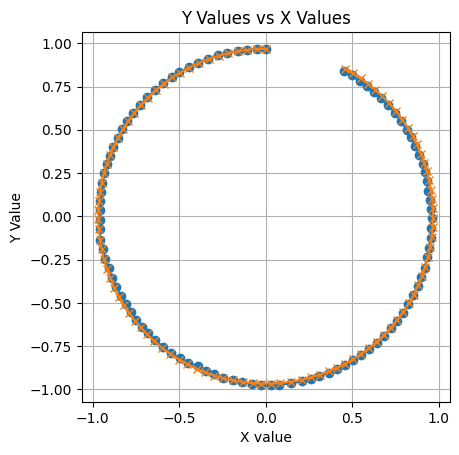

In [23]:
# Plot
# Create the plot
fig, ax = plt.subplots()


# Set aspect to be square
ax.set_aspect('equal') 
ax.plot(x_values_FRC_circle_samples_verify, y_values_FRC_circle_samples_verify, marker='o')
ax.plot(x_values_FRC_circle_samples, y_values_FRC_circle_samples, marker='x')
plt.title('Y Values vs X Values')
plt.xlabel('X value')
plt.ylabel('Y Value')
# Set aspect to be square
plt.grid(True)
plt.show()